# Poisson rSLDS 
## Behaving dataset
## Stim is as cue, system should come back to rest before lift 
## Fitting model from cue to grab, can I see 2 phases of dynamics? 

In [1]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, plot_dynamics_2d, plot_dynamics_3d
from matplotlib import colormaps
import pandas as pd

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D 

import random
import h5py

%matplotlib inline

In [2]:
path = f"/home/clewis/repos/realSpike/data/behavior/rb50_20250127/"

# Get data

In [3]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_cue_rec_time', 'aligned_laser_rec_time', 'any', 'cue', 'cue_rec_time', 'cue_trial_time', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'single', 'totTime', 'trial_start']>


# Plot the patterns

In [4]:
# visualize the patterns again
pattern_ids = list(np.unique(data['pattern_id'][:]))
len(pattern_ids)

30

In [5]:
from scipy.ndimage import zoom

In [6]:
reshape_size = 12

In [7]:
all_patterns = list()

for p_id in pattern_ids[3:]:
    ix = np.where(data['pattern_id'][:] == p_id)[1][0].astype(np.int32)
    pattern = np.zeros((data['pattern_xy'][0][ix].astype(np.int32), data['pattern_xy'][1][ix].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = f[data['pattern_fill'][ix, 0]]
    for x, y in zip(object_ref[0, :], object_ref[1, :]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    all_patterns.append(pattern)


In [8]:
len(all_patterns)

27

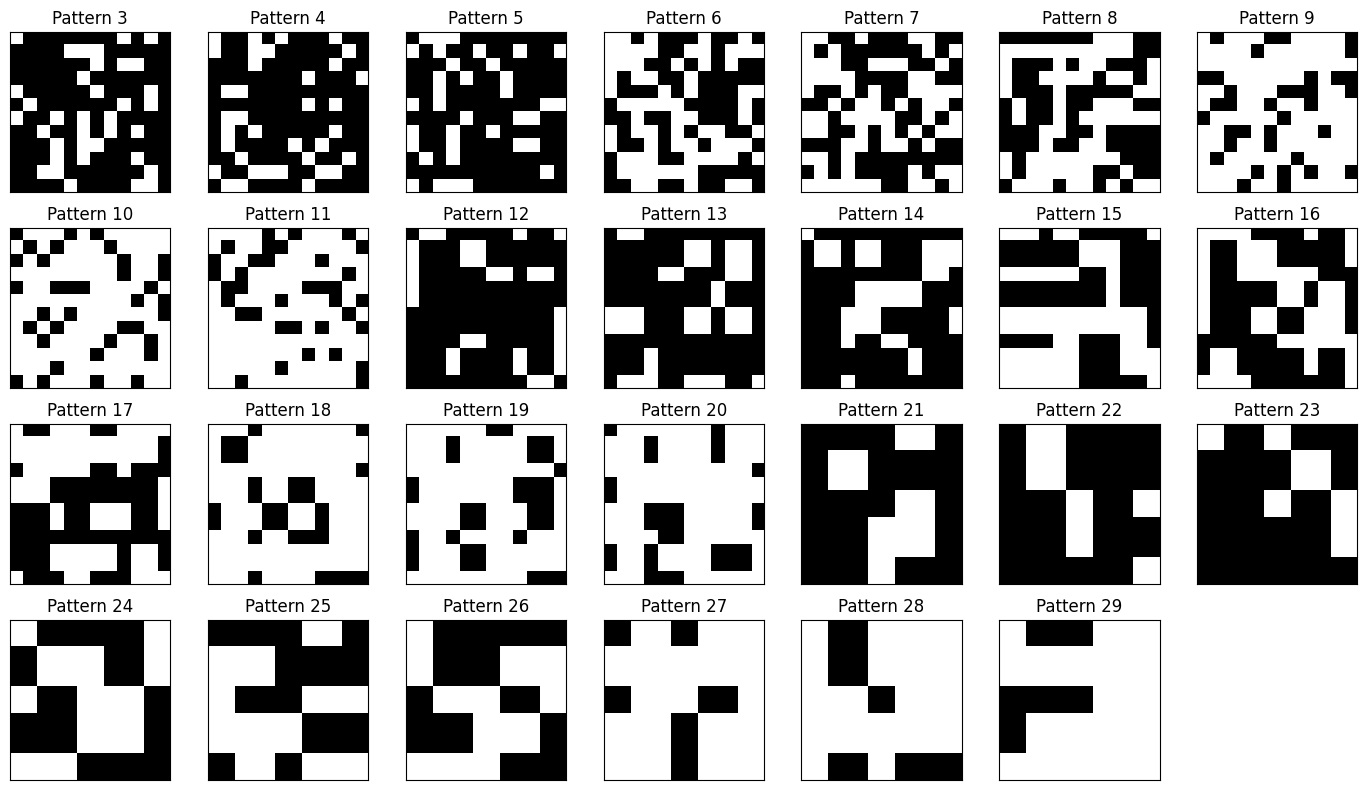

In [9]:
fig, axes = plt.subplots(4, 7, figsize=(14, 8))
axes = axes.flatten()

axes[-1].remove()

for i, p in enumerate(all_patterns):
    axes[i].matshow(p, cmap="binary") 
    axes[i].set_title(f"Pattern {i+3}") 

    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()

plt.savefig(f"{path}patterns.png")

plt.show()

# Get single-reach trials

In [10]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]
single_reach_idxs = np.where(data["single"][:, 0] == 1)

In [11]:
# get no laser trials
behavior_idxs = np.intersect1d(stim_idxs, single_reach_idxs)
behavior_idxs

array([ 17,  19,  20,  23,  24,  30,  36,  40,  43,  44,  46,  49,  50,
        53,  54,  60,  61,  62,  67,  70,  71,  74,  77,  82,  88,  89,
        91, 107, 116])

In [12]:
behavior_idxs.shape

(29,)

In [13]:
data["cue_rec_time"]

<HDF5 dataset "cue_rec_time": shape (450, 1), type "<f8">

## Get relevant time information

In [14]:
cue_times = data["cue_rec_time"][behavior_idxs, :]
cue_times

array([[ 378401.3027471 ],
       [ 412964.5048617 ],
       [ 430223.16624186],
       [ 481960.06796941],
       [ 499231.75682054],
       [ 603021.71245162],
       [ 706335.69338242],
       [ 775155.48003398],
       [ 826860.47389786],
       [ 844093.36354196],
       [ 878540.9232512 ],
       [ 930339.75266686],
       [ 947557.06598697],
       [ 999343.5287454 ],
       [1016540.9232512 ],
       [1120486.35891627],
       [1137781.83706221],
       [1155099.87727745],
       [1241575.09676201],
       [1293329.17964694],
       [1310604.83338053],
       [1362412.63098272],
       [1414270.55602757],
       [1500421.5047673 ],
       [1604049.56103087],
       [1621268.29038044],
       [1655724.06306051],
       [1932015.76512791],
       [2087651.09034268]])

In [15]:
lift_times = data["lift_ms"][behavior_idxs, :]
lift_times

array([[290.],
       [200.],
       [280.],
       [270.],
       [270.],
       [300.],
       [290.],
       [310.],
       [270.],
       [320.],
       [290.],
       [250.],
       [270.],
       [280.],
       [270.],
       [290.],
       [270.],
       [270.],
       [260.],
       [320.],
       [310.],
       [310.],
       [280.],
       [340.],
       [270.],
       [300.],
       [310.],
       [300.],
       [290.]])

In [16]:
grab_times = data["mouth_ms"][behavior_idxs, :]
grab_times

array([[520.],
       [510.],
       [630.],
       [480.],
       [520.],
       [570.],
       [670.],
       [570.],
       [510.],
       [640.],
       [560.],
       [480.],
       [520.],
       [490.],
       [590.],
       [520.],
       [550.],
       [570.],
       [520.],
       [550.],
       [580.],
       [650.],
       [510.],
       [570.],
       [480.],
       [570.],
       [550.],
       [530.],
       [500.]])

## Get the AP.bin file

In [17]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [18]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [19]:
meta_data = get_meta(meta_path)

In [20]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [21]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [22]:
vmax

0.6

In [23]:
imax

512.0

In [24]:
gain

500.0